# Purpose
The point of this notebook is to demonstrate how to perform at least one type of visual, marginal independence test.

In particular, the notebook will show how to visually test the following implication<br>
$
\begin{aligned}
P \left( X_1 \mid X_2 \right) &= P \left( X_1 \right) \\
\int x_1 P \left( X_1 \mid X_2 \right) \partial{x_1}  &= \int x_1 P \left( X_1 \right) \partial{x_1} \\
E \left[ X_1 \mid X_2 \right] &= E \left[ X_1 \right]
\end{aligned}
$

In other words, if $X_1$ is marginally independent of $X_2$, then the expectation of $X_1$ conditional on $X_2$ is equal to the marginal expectation of $X_1$. This implies that shuffling / permuting the $X_2$ columns should make no difference to predicting $X_1$, beyond predicting the mean of $X_1$.

In [1]:
# Declare hyperparameters for testing
NUM_PERMUTATIONS = 100

# Declare the columns to be used for testing
x1_col = 'num_licensed_drivers'
x2_col = 'num_cars'
mode_id_col = 'mode_id'

# Set the colors for plotting
permuted_color = '#a6bddb'

# Declare paths to data
DATA_PATH =\
    '../../data/raw/spring_2016_all_bay_area_long_format_plus_cross_bay_col.csv'

In [2]:
import sys

import numpy as np
import pandas as pd
from scipy.stats import multinomial

import seaborn as sbn
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm

sys.path.insert(0, '../../src/')
import testing.observable_independence as oi

In [3]:
# Load the raw data
df = pd.read_csv(DATA_PATH)

100%|██████████| 100/100 [00:00<00:00, 1168.71it/s]

num_licensed_drivers vs num_cars
The p-value of the permutation C.I.T. is 0.00.


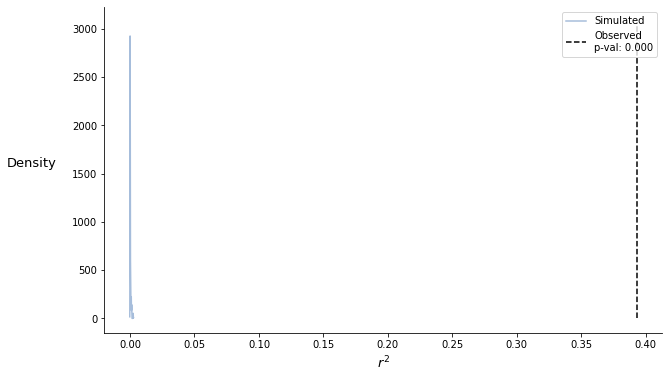

0.0

In [4]:
title_str = '{} vs {}'
print(title_str.format(x1_col, x2_col))

drive_alone_filter = df[mode_id_col] == 1
license_array = df.loc[drive_alone_filter, x1_col].values
num_cars_array = df.loc[drive_alone_filter, x2_col].values

oi.visual_permutation_test(
    license_array, num_cars_array, z_array=None,
    seed=1038,
    num_permutations=NUM_PERMUTATIONS,
    permutation_color=permuted_color)

## Test `visual_permutation_test`

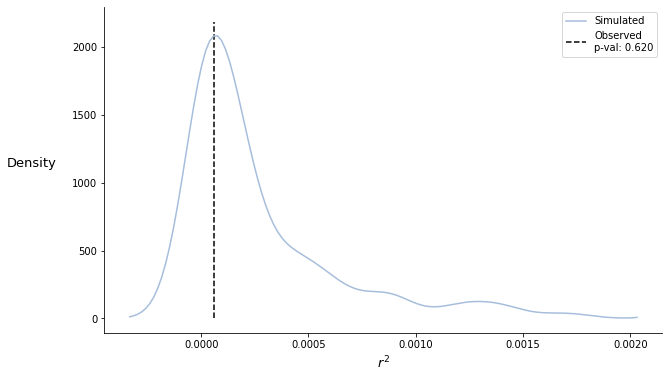

In [5]:
# Figure out how many observations to simulate, based on real data
num_drive_alone_obs = (df.mode_id == 1).sum()
# Determine how many simulations to carry out
NUM_TEST_SIM = 200

# Initialize an array to store the simulated p-values
test_p_vals = np.empty((NUM_TEST_SIM,), dtype=float)

# Set a random seed for reproducibility
np.random.seed(340)

# Compute the p-values of the visual permutation test when the
# null-hypothesis is true.
for i in tqdm(range(NUM_TEST_SIM)):
    # Simulate data that, by construction, satisfies x2 indep x1
    sim_x1 = 0.2 + 0.5 * np.random.normal(size=num_drive_alone_obs)
    sim_x2 = -0.1 - 0.01 * np.random.uniform(size=num_drive_alone_obs)

    # Determine which simulations to plot.
    # Just plot 1 simulation for visual comparison with real data
    current_close = True if i != 0 else False

    # Carry out the permutation test
    current_p =\
        oi.visual_permutation_test(
            sim_x1,
            sim_x2,
            z_array=None,
            seed=None,
            progress=False,
            verbose=False,
            show=False,
            close=current_close)
    # Store the resulting p-values
    test_p_vals[i] = current_p

/Users/timothyb0912/anaconda/envs/replicaAssgnmt/lib/python3.6/site-packages/ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


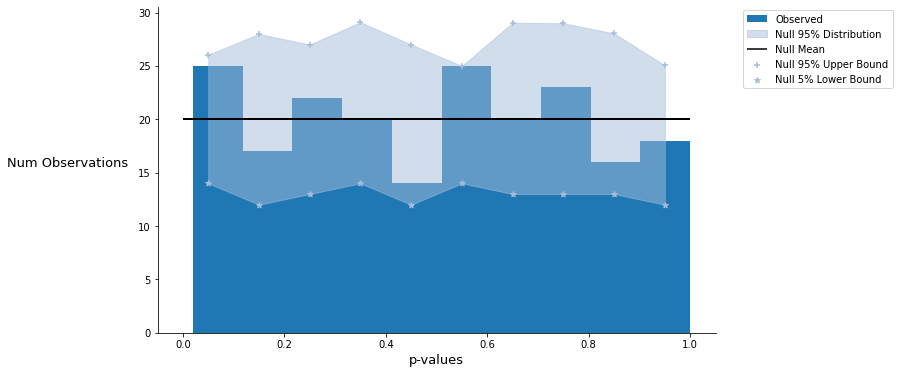

In [6]:
# Create a distribution of p-values that is for sure are uniformly distributed
null_histogram_dist = multinomial(NUM_TEST_SIM, [0.1 for x in range(10)])

null_hist_samples = null_histogram_dist.rvs(100)
null_hist_mean = null_histogram_dist.mean()
null_hist_upper_bound = np.percentile(null_hist_samples, 95, axis=0)
null_hist_lower_bound = np.percentile(null_hist_samples, 5, axis=0)

# Plot the distribution of our test p-values versus the p-values from
# a uniform distriburtion
fig, ax = plt.subplots(figsize=(10, 6))

plot_categories = [0.05 + 0.1 * x for x in range(10)]
ax.fill_between(plot_categories,
                null_hist_upper_bound,
                null_hist_lower_bound,
                color=permuted_color,
                label='Null 95% Distribution',
                alpha=0.5,
                zorder=2)

ax.hlines(null_hist_mean, 0, 1, label='Null Mean')

ax.hist(test_p_vals, bins=10, label='Observed', zorder=0)

ax.scatter(
    plot_categories,
    null_hist_upper_bound,
    label='Null 95% Upper Bound',
    color=permuted_color,
    marker='+',
    zorder=1)

ax.scatter(
    plot_categories,
    null_hist_lower_bound,
    label='Null 5% Lower Bound',
    color=permuted_color,
    marker='*',
    zorder=1)

ax.legend(loc=(1.05, 0.75))
ax.set_xlabel('p-values', fontsize=13)
ax.set_ylabel('Num Observations', rotation=0, labelpad=70, fontsize=13)

sbn.despine()
fig.show()

## Conclusions
- From the last plot, we can see that under the null hypothesis of $X_1$ independent of $X_2$, we get p-values that close to uniformly distributed.<br>
This means the permutation p-values in `visual_permutation_test` are unlikely to be overly-optimistic.<br>
In other words, we can feel safe(r) about relying on this test to distinguish conditional dependence from independence.
- From the first two plots of this notebook, we can see from applying the `visual_permutation_test` that the number of licensed drivers per household and number of automobiles per household are not marginally independent.